[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1suuoPuw8EKSYxnH6Shnv_tHuT4Qs9nnq?usp=sharing)

In [1]:
# 1. Сангуудыг импортлох
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# 2. Төхөөрөмж шалгах
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

# 3. MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 10.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.47MB/s]


In [4]:
# 4. CNN Загвар тодорхойлох
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # (batch, 1, 28, 28) -> (batch, 32, 28, 28)
        self.pool = nn.MaxPool2d(2, 2)               # -> (batch, 32, 14, 14)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # -> (batch, 64, 14, 14)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1, Loss: 0.1812
Epoch 2, Loss: 0.0491
Epoch 3, Loss: 0.0356
Epoch 4, Loss: 0.0259
Epoch 5, Loss: 0.0192
Accuracy: 98.78%


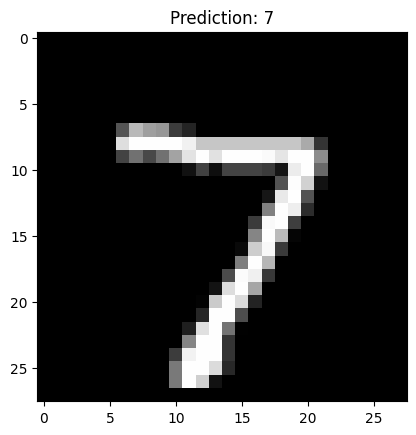

In [5]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. Сургалтын функц
def train(model, loader, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")

# 6. Үнэлгээний функц
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")




In [ ]:
# 7. Модел хадгалах функц
def save_model(model, path="model.pth"):
    torch.save(model.state_dict(), path)

# 8. Модел ачаалж inference хийх функц
def load_model(path="model.pth"):
    model = CNN().to(device)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

def predict(model, image):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))  # (1, 1, 28, 28)
        prediction = output.argmax(dim=1, keepdim=True)
        return prediction.item()

# 9. Загвар сургалт, хадгалалт, үнэлгээ
train(model, train_loader, epochs=5)
evaluate(model, test_loader)
save_model(model)

# 10. Загвар ачаалж зураг таамаглах (inference)
loaded_model = load_model()
example_data, _ = test_dataset[0]
plt.imshow(example_data.squeeze(), cmap='gray')
plt.title(f"Prediction: {predict(loaded_model, example_data)}")
plt.show()